In [1]:
import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.metrics import AUC, Mean
from tensorflow.keras.models import load_model

from deepctr.feature_column import DenseFeat, get_feature_names, SparseFeat
from deepctr.callbacks import ModifiedExponentialDecay
from deepctr.layers import custom_objects
from deepctr.layers.utils import NoMask
from deepctr.models.gbdt2nn.basenet import GBDT_FM
from deepctr import metrics as utils
from deepctr.models.gbdt2nn.encoding_nume import NumEncoder
from deepctr.models.gbdt2nn.encoding_cate import CateEncoder
from deepctr.models.gbdt2nn.gbdt_predict_leaf import gbdt_predict
from deepctr.models.gbdt2nn.leaf2emb import EmbeddingLeafModel, Embedding2Score, Leaf2Embedding

import seaborn as sns
import matplotlib.pyplot as plt
import toad


custom_objects['NoMask'] = NoMask
custom_objects['Mean'] = Mean
custom_objects['AUC'] = AUC
custom_objects['ModifiedExponentialDecay'] = ModifiedExponentialDecay
custom_objects['Embedding2Score'] = Embedding2Score
custom_objects['Leaf2Embedding'] = Leaf2Embedding
custom_objects['EmbeddingLeafModel'] = EmbeddingLeafModel
train_cate = pd.read_csv('../data/risk_offline/risk_offline_cate/train/train_cate.csv')
test_cate = pd.read_csv('../data/risk_offline/risk_offline_cate/test/test_cate.csv')

In [2]:
def load_data(data_dir='../data/risk_offline', persist=True):
    trn_x = np.load(data_dir+"/train_features.npy").astype(np.float32)
    trn_y = np.load(data_dir+"/train_labels.npy").astype(np.float32)
    vld_x = np.load(data_dir+"/test_features.npy").astype(np.float32)
    vld_y = np.load(data_dir+"/test_labels.npy").astype(np.float32)

    vld_x1 = np.load(data_dir+"/test_3oot_features.npy").astype(np.float32)
    vld_y1= np.load(data_dir+"/test_3oot_labels.npy").astype(np.float32)
    vld_x2 = np.load(data_dir+"/test_4oot_features.npy").astype(np.float32)
    vld_y2 = np.load(data_dir+"/test_4oot_labels.npy").astype(np.float32)
    vld_x3 = np.load(data_dir+"/test_5oot_features.npy").astype(np.float32)
    vld_y3 = np.load(data_dir+"/test_5oot_labels.npy").astype(np.float32)

    mean = np.mean(trn_x, axis=0)
    std = np.std(trn_x, axis=0)

    if persist:
        joblib.dump({'mean': mean, 'std': std}, 'scaler.pkl')

    trn_x = (trn_x - mean) / (std + 1e-5)
    vld_x = (vld_x - mean) / (std + 1e-5)

    vld_x1 = (vld_x1 - mean) / (std + 1e-5)
    vld_x2 = (vld_x2 - mean) / (std + 1e-5)
    vld_x3 = (vld_x3 - mean) / (std + 1e-5)

    return trn_x, trn_y, vld_x, vld_y, vld_x1, vld_y1, vld_x2, vld_y2, vld_x3, vld_y3


def load_lightgbm(path):
    import pickle
    pkl_file = open(path, 'rb')
    gbm = pickle.load(pkl_file)
    pkl_file.close()
    return gbm

gbm_original = load_lightgbm('../data/risk_offline/lightgbm_model.pickle')
gbm = load_lightgbm('../data/risk_offline/lightgbm_model2.pickle')

In [3]:
# data used for leaf embedding model
args = {'nslices': 1, 'maxleaf': 2, 'embsize': 32, 'feat_per_group': 200,
        'group_method': 'Equal'}
train_x, train_y, test_x, test_y, \
oot1_x, oot1_y, oot2_x, oot2_y, oot3_x, oot3_y = load_data('../data/risk_offline/risk_offline_nume',
                                                           persist=False)

In [4]:
# # feature distributions before embedding
# for i in range(test_x.shape[1]):
#     feature = test_x[:, i]
#     fig, ax = plt.subplots()
#     sns.distplot(feature, ax=ax)

In [5]:
# get gbdt-leaf indexing, which will be used as the input for embedding model
leaf_preds, test_leaf_preds, tree_outputs, test_tree_outputs, \
group_average, used_features, n_models, max_ntree_per_split, min_len_features = \
    gbdt_predict(train_x, test_x, gbm, args)
model_input = {'gbm_leaf_predictions': leaf_preds}
test_model_input = {'gbm_leaf_predictions': test_leaf_preds}

Model Interpreting...
[(16,)]


In [6]:
# leaf embedding
emb_model = EmbeddingLeafModel([DenseFeat('gbm_leaf_predictions', leaf_preds.shape[1])],
                               n_models,
                               args['maxleaf'] + 1,
                               args['embsize'],
                               'binary',
                               group_average)
opt = tf.keras.optimizers.Adam(learning_rate=ModifiedExponentialDecay(0.001, max_iter_num=100))
tree_outputs = np.asarray(tree_outputs).reshape((n_models, leaf_preds.shape[0])).transpose((1, 0))
test_tree_outputs = np.asarray(test_tree_outputs).reshape((n_models, test_leaf_preds.shape[0])).transpose((1, 0))
emb_model.compile(loss=['mse', None], optimizer=opt, metrics=[['mse'], ['AUC']])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_final_score_auc',
                                            patience=5,
                                            mode='max',
                                            restore_best_weights=True)
history = emb_model.fit(model_input, [tree_outputs, train_y],
                        batch_size=256,
                        validation_data=(test_model_input, [test_tree_outputs, test_y]),
                        epochs=100,
                        callbacks=[callback]
                       )
model_new = tf.keras.Model(inputs=emb_model.input, outputs=emb_model.get_layer('leaf2emb').output)

Epoch 1/100
32/32 [==============================] - 2s 22ms/step - loss: 10.9462 - emb2score_loss: 10.9462 - emb2score_mse: 10.9462 - final_score_auc: 0.3744 - val_loss: 7.9908 - val_emb2score_loss: 7.9908 - val_emb2score_mse: 7.9908 - val_final_score_auc: 0.3758
Epoch 2/100
32/32 [==============================] - 0s 12ms/step - loss: 4.6373 - emb2score_loss: 4.6373 - emb2score_mse: 4.6373 - final_s

In [7]:
# # features distribution after embedding
# temp = model_new.predict(test_model_input)
# for i in range(temp.shape[1]):
#     feature = temp[:, i]
#     fig, ax = plt.subplots()
#     sns.distplot(feature, ax=ax)

In [8]:
# input for gbdt_fm model
train_cate = pd.read_csv('../data/risk_offline/risk_offline_cate/train/train_cate.csv')
test_cate = pd.read_csv('../data/risk_offline/risk_offline_cate/test/test_cate.csv')
sparse_features = ['ali_rain_score', 'bj_jc_m36_consume_cnt', 'td_zhixin_score',
                   'hds_36m_purchase_steady',
            'hds_36m_total_purchase_cnt', 'hds_36m_month_max_purchase_money_excp_doub11_12',
            'hds_36m_doub11_12_total_purchase_money', 'ab_local_ratio',
                   'ab_mobile_cnt', 'cust_id_area',
            'cust_work_city', 'immediate_relation_cnt', 'relation_contact_cnt', 'study_app_cnt',
            'ab_local_cnt', 'ab_prov_cnt', 'credit_repayment_score_bj_2',
                   'td_xyf_dq_score'] + \
           ['hds_phone_rich_rank', 'hds_mobile_rich', 'hds_recent_consumme_active_rank',
            'idcard_district_grade',
            'idcard_rural_flag', 'selffill_degree', 'selffill_is_have_creditcard',
            'selffill_marital_status',
            'hds_mobile_reli_rank_Ma', 'hds_mobile_reli_rank_Mb',
            'hds_mobile_reli_rank_M0', 'is_ios', 'is_male']
train_cate[sparse_features] = train_cate[sparse_features].replace([-1], 0)
test_cate[sparse_features] = test_cate[sparse_features].replace([-1], 0)
cat_feature_columns = [SparseFeat(feat, vocabulary_size=train_cate[feat].max() + 1,
                                  embedding_dim=4) for i, feat in enumerate(sparse_features)]
num_feature_columns = [DenseFeat('gbm_leaf_predictions', leaf_preds.shape[1])]
dnn_feature_columns = cat_feature_columns + num_feature_columns
linear_feature_columns = cat_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)
train_cate_input = {name: train_cate[name] if name != 'gbm_leaf_predictions'
                    else leaf_preds for name in feature_names }
test_cate_input = {name: test_cate[test_cate['set'] == '2test'][name]
                   if name != 'gbm_leaf_predictions' else test_leaf_preds
                   for name in feature_names}

In [7]:
# gbdt_fm model
model2 = GBDT_FM(linear_feature_columns, dnn_feature_columns, model_new,
                 num_outdim=1, dnn_hidden_units=(32, 16), dnn_use_bn=False,
                 l2_reg_embedding=1e-5, l2_reg_dnn=1e-5, dnn_dropout=0,
                 dnn_activation='relu', seed=1024)
optimizer = keras.optimizers.Adam(learning_rate=ModifiedExponentialDecay(0.001, max_iter_num=100))
model2.compile(optimizer=optimizer,
               loss=keras.losses.binary_crossentropy,
               metrics=AUC(name='task1_AUC'))
history = model2.fit(train_cate_input,
                     train_y,
                     batch_size=32,
                     epochs=3,
                     validation_data=(test_cate_input, test_y),
                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_task1_AUC',
                                                                 patience=10,
                                                                 mode='max',
                                                                 restore_best_weights=True)
                               ]
                     )

Epoch 1/3
252/252 [==============================] - 22s 75ms/step - loss: 0.1613 - task1_AUC: 0.6256 - val_loss: 0.1433 - val_task1_AUC: 0.6958

In [ ]:
model2.save('../data/risk_offline/model.h5')

In [9]:
model2 = load_model('../data/risk_offline/model.h5', custom_objects=custom_objects)

-----
Model Interpreting...
[(16,)]
(0.36745346815846386, 0.034137286) 0.7396913183651971
-----
Model Interpreting...
[(16,)]
(0.3451032874321558, 0.038792472) 0.7089153156537494
-----
Model Interpreting...
[(16,)]
(0.29291467224626677, 0.024451265) 0.6927446090936016
-----
Model Interpreting...
[(16,)]
(0.36959459459459465, 0.039633784) 0.7206857195032872
-----
Model Interpreting...
[(16,)]
(0.2841616521803729, 0.038360722) 0.6588923556942278


D:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

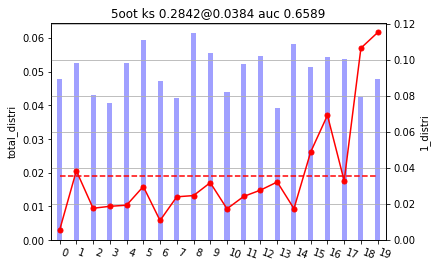

In [9]:
# prediction
pred_y = model2.predict(train_cate_input)
train_cate['pred'] = pred_y
selected_psi = ['pred']
target = 'fpd4'
combiner = toad.transform.Combiner()
combiner.fit(train_cate[train_cate['set'] == '1train'][selected_psi + [target]],
             y=target,
             n_bins=20,
             method='quantile',
             empty_separate=True)
dataset = ((train_x, train_y), (test_x, test_y),
           (oot1_x, oot1_y), (oot2_x, oot2_y), (oot3_x, oot3_y))
for index, i in enumerate(['1train', '2test', '3oot', '4oot', '5oot']):
    print('-----')
    leaf_preds, test_leaf_preds, tree_outputs, test_tree_outputs, \
    group_average, used_features, n_models, max_ntree_per_split, min_len_features = \
        gbdt_predict(dataset[0][0], dataset[index][0], gbm, args)
    if i == '1train':
        test_cate_input = {name: train_cate[train_cate['set'] == i][name]
                           if name != 'gbm_leaf_predictions' else test_leaf_preds
                           for name in feature_names}
        df = train_cate[train_cate['set'] == i]
    else:
        test_cate_input = {name: test_cate[test_cate['set'] == i][name]
                           if name != 'gbm_leaf_predictions' else test_leaf_preds
                           for name in feature_names}
        df = test_cate[test_cate['set'] == i]
    df['pred'] = model2.predict(test_cate_input)
    ks = utils.cal_ks(df['pred'].values, df['fpd4'].values)
    auc = roc_auc_score(df['fpd4'].values, df['pred'].values)
    plt.close('all')
    df['range'] = combiner.transform(df['pred'])
    print(ks, auc)
    table, ax = utils.calc_lift3(df, 'range', 'fpd4',
                                 range_col='range',
                                 title_name=i +' ks {:.4f}@{:.4f} auc {:.4f}'.format(ks[0],
                                                                                     ks[1],
                                                                                     auc))
    plt.savefig(i+'.jpg')

In [10]:
# total performace evaluation
# get total oot
score_cols = ['basic_lr_score', 'k3dq_jst_re_score', 'k3dq_basic_mix_score',
              'k3dq_xgb_add_score', 'k3dq_bc1_score', 'k3dq_bc2_score',
              'k3dq_v2new_score', 'k3dq_xgblr_score', 'k3dq_xgbkmos_score',
              'k3dq_xgbkmos_flag', 'k3dq_v3m3k11_score', 'k3dq_transkmos_score']
oot_df = pd.concat([test_cate[test_cate['set'] == '3oot'],
                    test_cate[test_cate['set'] == '4oot'],
                    test_cate[test_cate['set'] == '5oot']], axis=0).reset_index()

In [11]:
# predict on total oot
leaf_preds, test_leaf_preds, tree_outputs, test_tree_outputs, \
group_average, used_features, n_models, max_ntree_per_split, min_len_features = \
    gbdt_predict(train_x, np.concatenate([oot1_x, oot2_x, oot3_x], axis=0), gbm, args)
test_cate_input = {name: oot_df[name] if name != 'gbm_leaf_predictions' else test_leaf_preds
                   for name in feature_names}
oot_df['pred'] = model2.predict(test_cate_input)

Model Interpreting...
[(16,)]


In [10]:
# correlations of model scores on total oot
print(oot_df[score_cols+['pred']].replace([-99, 0], np.nan).corr())

                      basic_lr_score  k3dq_jst_re_score  k3dq_basic_mix_score  \
basic_lr_score              1.000000           0.337024              0.247494   
k3dq_jst_re_score           0.337024           1.000000              0.454816   
k3dq_basic_mix_score        0.247494           0.454816              1.000000   
k3dq_xgb_add_score          0.402992           0.438347              0.708797   
k3dq_bc1_score              0.337143           0.284630              0.182166   
k3dq_bc2_score              0.394035           0.321029              0.198948   
k3dq_v2new_score            0.257790           0.502711              0.460878   
k3dq_xgblr_score            0.289361           0.455155              0.653999   
k3dq_xgbkmos_score          0.285342           0.504152              0.618006   
k3dq_xgbkmos_flag                NaN                NaN                   NaN   
k3dq_v3m3k11_score          0.367794           0.465262              0.516431   
k3dq_transkmos_score        

In [12]:
oot_df[score_cols+['pred']].replace([-99, 0, -1], np.nan).corr().to_csv('corr.csv')

(0.2938675068834332, 0.038188376) 0.6858181404684047


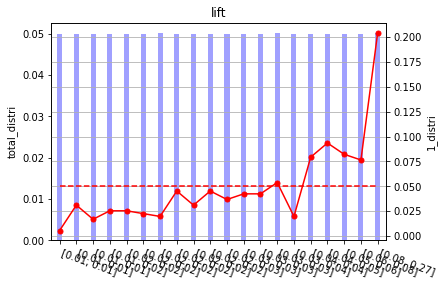

In [19]:
# ks and auc of total oot
ks = utils.cal_ks(oot_df['pred'].values, oot_df['fpd4'].values)
auc = roc_auc_score(oot_df['fpd4'].values, oot_df['pred'].values)
print(ks, auc)
plt.close('all')
table, ax = utils.calc_lift3(oot_df, 'pred', 'fpd4', groupnum=20)
plt.show()

In [36]:
table

,group,good,bad,count,range,good_distri,bad_distri,total_distri,cumgood_distri,cumbad_distri,badrate,cumbadrate,lift,ks
0,1.0,657,2,659,"[0.01, 0.01]",0.051208,0.005666,0.049989,0.051208,0.005666,0.003035,0.003035,0.113340,0.045542
1,2.0,648,11,659,"[0.01, 0.01]",0.050507,0.031161,0.049989,0.101715,0.036827,0.016692,0.009863,0.623371,0.064888
2,3.0,653,6,659,"[0.01, 0.01]",0.050896,0.016997,0.049989,0.152611,0.053824,0.009105,0.009611,0.340021,0.098787
3,4.0,650,9,659,"[0.01, 0.02]",0.050663,0.025496,0.049989,0.203274,0.079320,0.013657,0.010622,0.510031,0.123953
4,5.0,650,9,659,"[0.02, 0.02]",0.050663,0.025496,0.049989,0.253936,0.104816,0.013657,0.011229,0.510031,0.149120
5,6.0,651,8,659,"[0.02, 0.02]",0.050740,0.022663,0.049989,0.304677,0.127479,0.012140,0.011381,0.453361,0.177198
6,7.0,653,7,660,"[0.02, 0.02]",0.050896,0.019830,0.050064,0.355573,0.147309,0.010606,0.011270,0.396090,0.208264
7,8.0,643,16,659,"[0.02, 0.02]",0.050117,0.045326,0.049989,0.405690,0.192635,0.024279,0.012896,0.906722,0.213055
8,9.0,648,11,659,"[0.02, 0.02]",0.050507,0.031161,0.049989,0.456196,0.223796,0.016692,0.013318,0.623371,0.232400
9,10.0,643,16,659,"[0.02, 0.02]",0.050117,0.045326,0.049989,0.506313,0.269122,0.024279,0.014414,0.906722,0.237192


0.29484123391749595 0.6840897197829979


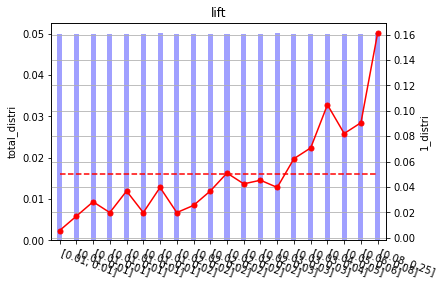

In [66]:
# week lightgbm performance on total oot
pred_y = gbm.predict(np.concatenate([oot1_x, oot2_x, oot3_x], axis=0))
auc = roc_auc_score(np.concatenate([oot1_y, oot2_y, oot3_y], axis=0), pred_y)
fpr, tpr, _ = roc_curve(np.concatenate([oot1_y, oot2_y, oot3_y], axis=0), pred_y)
ks = np.max(np.abs(tpr - fpr))
print(ks, auc)
oot_df['pred2'] = pred_y
plt.close('all')
table, ax = utils.calc_lift3(oot_df, 'pred2', 'fpd4', groupnum=20)
plt.show()

In [19]:
table

,group,good,bad,count,range,good_distri,bad_distri,total_distri,cumgood_distri,cumbad_distri,badrate,cumbadrate,lift,ks
0,1.0,657,2,659,"[0.01, 0.01]",0.051208,0.005666,0.049989,0.051208,0.005666,0.003035,0.003035,0.113340,0.045542
1,2.0,653,6,659,"[0.01, 0.01]",0.050896,0.016997,0.049989,0.102104,0.022663,0.009105,0.006070,0.340021,0.079442
2,3.0,649,10,659,"[0.01, 0.01]",0.050585,0.028329,0.049989,0.152689,0.050992,0.015175,0.009105,0.566701,0.101698
3,4.0,652,7,659,"[0.01, 0.01]",0.050818,0.019830,0.049989,0.203507,0.070822,0.010622,0.009484,0.396691,0.132686
4,5.0,646,13,659,"[0.01, 0.01]",0.050351,0.036827,0.049989,0.253858,0.107649,0.019727,0.011533,0.736712,0.146209
5,6.0,652,7,659,"[0.01, 0.01]",0.050818,0.019830,0.049989,0.304677,0.127479,0.010622,0.011381,0.396691,0.177198
6,7.0,646,14,660,"[0.01, 0.02]",0.050351,0.039660,0.050064,0.355027,0.167139,0.021212,0.012787,0.792180,0.187888
7,8.0,652,7,659,"[0.02, 0.02]",0.050818,0.019830,0.049989,0.405846,0.186969,0.010622,0.012517,0.396691,0.218877
8,9.0,650,9,659,"[0.02, 0.02]",0.050663,0.025496,0.049989,0.456508,0.212465,0.013657,0.012643,0.510031,0.244044
9,10.0,646,13,659,"[0.02, 0.02]",0.050351,0.036827,0.049989,0.506859,0.249292,0.019727,0.013352,0.736712,0.257567


0.30968008319735746 0.6838738879971031


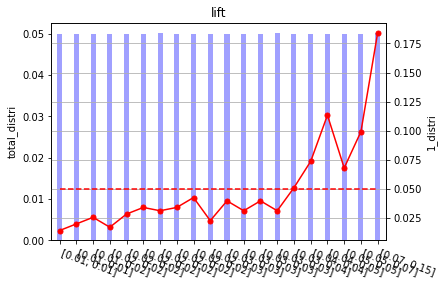

In [20]:
# strong lightgbm performance on total oot
pred_y = gbm_original.predict(np.concatenate([oot1_x, oot2_x, oot3_x], axis=0))
auc = roc_auc_score(np.concatenate([oot1_y, oot2_y, oot3_y], axis=0), pred_y)
fpr, tpr, _ = roc_curve(np.concatenate([oot1_y, oot2_y, oot3_y], axis=0), pred_y)
ks = np.max(np.abs(tpr - fpr))
print(ks, auc)
oot_df['pred2'] = pred_y
plt.close('all')
table, ax = utils.calc_lift3(oot_df, 'pred2', 'fpd4', groupnum=20)
plt.show()

In [37]:
# original k3dq score on total oot
temp = oot_df[oot_df.k3dq_xgb_add_score.notnull()]
ks = utils.cal_ks(temp['k3dq_xgb_add_score'].values, temp['fpd4'].values)
auc = roc_auc_score(temp['fpd4'].values, temp['k3dq_xgb_add_score'].values)
print(ks, auc)

(0.2736069004743524, 0.043133624) 0.6802573320301067


In [9]:
# save the preprocessing procedures for numerical features
nume_col = ['ali_rain_score', 'bj_jc_m36_consume_cnt', 'td_zhixin_score',
            'hds_36m_purchase_steady',
            'hds_36m_total_purchase_cnt', 'hds_36m_month_max_purchase_money_excp_doub11_12',
            'hds_36m_doub11_12_total_purchase_money', 'ab_local_ratio', 'ab_mobile_cnt',
            'cust_id_area',
            'cust_work_city', 'immediate_relation_cnt', 'relation_contact_cnt',
            'study_app_cnt',
            'ab_local_cnt', 'ab_prov_cnt', 'credit_repayment_score_bj_2', 'td_xyf_dq_score']
cate_col = ['hds_phone_rich_rank', 'hds_mobile_rich', 'hds_recent_consumme_active_rank',
            'idcard_district_grade',
            'idcard_rural_flag', 'selffill_degree', 'selffill_is_have_creditcard',
            'selffill_marital_status',
            'hds_mobile_reli_rank_Ma', 'hds_mobile_reli_rank_Mb', 'hds_mobile_reli_rank_M0',
            'is_ios', 'is_male']
label_col = 'fpd4'


In [10]:
ec = NumEncoder(cate_col, nume_col, 10, 0.99, label_col)
df = pd.read_csv('../data/risk_offline/train.csv')
ec.fit_transform(df[nume_col+cate_col],
                 '../data/risk_offline/risk_offline_num/train',
                 df[label_col],
                 persist=False)

100%|██████████| 13/13 [00:00<00:00, 14.77it/s]


----------------------------------------------------------------------
Fitting and Transforming.
----------------------------------------------------------------------
8060
Filtering and fillna features
Ordinal encoding cate features
Target encoding cate features
Start manual binary encode
hds_phone_rich_rank
hds_mobile_rich
hds_recent_consumme_active_rank
idcard_district_grade
idcard_rural_flag
selffill_degree
selffill_is_have_creditcard
selffill_marital_status
hds_mobile_reli_rank_Ma
hds_mobile_reli_rank_Mb
hds_mobile_reli_rank_M0
is_ios
is_male


(array([[ 73.2       ,   8.37596048, 677.        , ...,   0.        ,
           1.        ,   0.        ],
        [ 81.82      ,   2.        , 771.        , ...,   1.        ,
           0.        ,   1.        ],
        [ 37.52      ,  15.        , 583.        , ...,   1.        ,
           1.        ,   0.        ],
        ...,
        [ 94.54      ,   1.        , 672.        , ...,   0.        ,
           0.        ,   1.        ],
        [ 36.6       ,   1.        , 647.        , ...,   0.        ,
           0.        ,   1.        ],
        [ 95.08      ,   3.        , 665.        , ...,   1.        ,
           0.        ,   1.        ]]),
 array([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]], dtype=int64))

In [5]:
df = pd.read_csv('../data/risk_offline/test.csv')
for data_type in ['2test', '3oot', '4oot', '5oot']:
    vld_x = ec.predict(df[df['set'] == data_type].reset_index(drop=True)[nume_col+cate_col])
    vld_y = df[df['set'] == data_type].reset_index(drop=True)[label_col].values.reshape(-1, 1)
    if data_type != '2test':
        ff_x = np.load('../data/risk_offline/risk_offline_nume/test_{}_features.npy'.format(data_type))
        ff_y = np.load('../data/risk_offline/risk_offline_nume/test_{}_labels.npy'.format(data_type))
        np.testing.assert_almost_equal(vld_x, ff_x)
        np.testing.assert_almost_equal(vld_y, ff_y)

Filtering and fillna features
Ordinal encoding cate features
Target encoding cate features
Filtering and fillna features
Ordinal encoding cate features
Target encoding cate features
Filtering and fillna features
Ordinal encoding cate features
Target encoding cate features
Filtering and fillna features
Ordinal encoding cate features
Target encoding cate features


In [11]:
import dill
dill.dump(ec, open('../data/risk_offline/numerical_encoder.pkl', 'wb'))

In [12]:
encoder = joblib.load('../data/risk_offline/numerical_encoder.pkl')

In [13]:
df = pd.read_csv('../data/risk_offline/test.csv')
for data_type in ['2test', '3oot', '4oot', '5oot']:
    vld_x = encoder.predict(df[df['set'] == data_type].reset_index(drop=True)[nume_col+cate_col])
    vld_y = df[df['set'] == data_type].reset_index(drop=True)[label_col].values.reshape(-1, 1)
    if data_type != '2test':
        ff_x = np.load('../data/risk_offline/risk_offline_nume/test_{}_features.npy'.format(data_type))
        ff_y = np.load('../data/risk_offline/risk_offline_nume/test_{}_labels.npy'.format(data_type))
        np.testing.assert_almost_equal(vld_x, ff_x)
        np.testing.assert_almost_equal(vld_y, ff_y)

Filtering and fillna features
Ordinal encoding cate features
Target encoding cate features
Filtering and fillna features
Ordinal encoding cate features
Target encoding cate features
Filtering and fillna features
Ordinal encoding cate features
Target encoding cate features
Filtering and fillna features
Ordinal encoding cate features
Target encoding cate features


In [16]:
# save the preprocessing procedures for categorical features
nume_col = ['ali_rain_score', 'bj_jc_m36_consume_cnt', 'td_zhixin_score',
            'hds_36m_purchase_steady',
            'hds_36m_total_purchase_cnt', 'hds_36m_month_max_purchase_money_excp_doub11_12',
            'hds_36m_doub11_12_total_purchase_money', 'ab_local_ratio', 'ab_mobile_cnt',
            'cust_id_area',
            'cust_work_city', 'immediate_relation_cnt', 'relation_contact_cnt',
            'study_app_cnt',
            'ab_local_cnt', 'ab_prov_cnt', 'credit_repayment_score_bj_2', 'td_xyf_dq_score']
cate_col = ['hds_phone_rich_rank', 'hds_mobile_rich', 'hds_recent_consumme_active_rank',
            'idcard_district_grade',
            'idcard_rural_flag', 'selffill_degree', 'selffill_is_have_creditcard',
            'selffill_marital_status',
            'hds_mobile_reli_rank_Ma', 'hds_mobile_reli_rank_Mb', 'hds_mobile_reli_rank_M0',
            'is_ios', 'is_male']
label_col = 'fpd4'

In [17]:
ec = CateEncoder(cate_col, nume_col,
                 10, 0.99, 10,
                 label_col)

df = pd.read_csv('../data/risk_offline/train.csv')
_ = ec.fit_transform(df[nume_col+cate_col],
                     '../data/risk_offline/risk_offline_cate/train/',
                     df[label_col],
                     persist=False)

100%|██████████| 18/18 [00:00<00:00, 384.02it/s]


----------------------------------------------------------------------
Fitting and Transforming.
----------------------------------------------------------------------
Filtering and fillna features
Fillna and Bucketize numeric features
train
bj_jc_m36_consume_cnt
train
td_zhixin_score
train
hds_36m_purchase_steady
train
hds_36m_total_purchase_cnt
train
hds_36m_month_max_purchase_money_excp_doub11_12
train
hds_36m_doub11_12_total_purchase_money
train
ab_local_ratio
train
ab_mobile_cnt
train
immediate_relation_cnt
train
relation_contact_cnt
train
study_app_cnt
train
ab_local_cnt
train
ab_prov_cnt
train
credit_repayment_score_bj_2
train
td_xyf_dq_score
Ordinal encoding cate features


In [ ]:
df = pd.read_csv('../data/risk_offline/test.csv')
vld_x = ec.predict(df[nume_col+cate_col])
ff_x = pd.read_csv('../data/risk_offline/risk_offline_cate/test/test_cate.csv')
np.testing.assert_almost_equal(vld_x[nume_col+cate_col].values,
                               ff_x[nume_col+cate_col].values)

In [18]:
joblib.dump(ec,  '../data/risk_offline/categorical_encoder.pkl')

['../data/risk_offline/categorical_encoder.pkl']

In [23]:
# online prediction code
oot_df2 = pd.read_csv('../data/risk_offline/test.csv')
oot_df2 = pd.concat([oot_df2[oot_df2['set'] == '3oot'],
                     oot_df2[oot_df2['set'] == '4oot'],
                     oot_df2[oot_df2['set'] == '5oot']], axis=0).reset_index(drop=True)

In [25]:
args = {'nslices': 1, 'maxleaf': 2, 'embsize': 32, 'feat_per_group': 200, 'group_method': 'Equal'}
scaler = joblib.load('../data/risk_offline/scaler.pkl')
categorical_encoder = joblib.load('../data/risk_offline/categorical_encoder.pkl')
numerical_encoder = joblib.load('../data/risk_offline/numerical_encoder.pkl')
gbm_model = load_lightgbm('../data/risk_offline/lightgbm_model2.pickle')
gbdt_fm_model = load_model('../data/risk_offline/model.h5', custom_objects=custom_objects)
feature_names = ['ali_rain_score', 'bj_jc_m36_consume_cnt', 'td_zhixin_score',
                 'hds_36m_purchase_steady', 'hds_36m_total_purchase_cnt',
                 'hds_36m_month_max_purchase_money_excp_doub11_12',
                 'hds_36m_doub11_12_total_purchase_money', 'ab_local_ratio',
                 'ab_mobile_cnt', 'cust_id_area', 'cust_work_city', 'immediate_relation_cnt',
                 'relation_contact_cnt', 'study_app_cnt', 'ab_local_cnt', 'ab_prov_cnt',
                 'credit_repayment_score_bj_2', 'td_xyf_dq_score', 'hds_phone_rich_rank',
                 'hds_mobile_rich', 'hds_recent_consumme_active_rank', 'idcard_district_grade',
                 'idcard_rural_flag', 'selffill_degree', 'selffill_is_have_creditcard',
                 'selffill_marital_status', 'hds_mobile_reli_rank_Ma', 'hds_mobile_reli_rank_Mb',
                 'hds_mobile_reli_rank_M0', 'is_ios', 'is_male', 'gbm_leaf_predictions']
df_gbdt = numerical_encoder.predict(oot_df2[nume_col+cate_col])
df_gbdt = df_gbdt.astype(np.float32)
df_gbdt = (df_gbdt - scaler['mean']) / (scaler['std'] + 1e-5)
df_fm = categorical_encoder.predict(oot_df2[nume_col+cate_col])
df_fm = df_fm.replace([-1], 0)

Filtering and fillna features
Ordinal encoding cate features
Target encoding cate features
Filtering and fillna features
Ordinal encoding cate features


100%|██████████| 18/18 [00:00<00:00, 691.83it/s]


In [26]:
leaf_preds, test_leaf_preds, tree_outputs, test_tree_outputs, \
group_average, used_features, n_models, max_ntree_per_split, min_len_features = \
    gbdt_predict(df_gbdt, df_gbdt, gbm_model, args)
test_cate_input2 = {name: df_fm[name] if name != 'gbm_leaf_predictions' else test_leaf_preds
                   for name in feature_names}

Model Interpreting...
[(16,)]


In [27]:
result = gbdt_fm_model.predict(test_cate_input2)

In [36]:
np.testing.assert_almost_equal(result[:, 0], oot_df['pred'].values)

In [12]:
oot_df[['pred']].to_csv('dd.csv', index=None)